<a href="https://colab.research.google.com/github/melodyrous/mutidim/blob/master/colabs/TP2_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse de données multidimensionnelles
## Entrez ici vos noms et prénoms

# TP 2: Utiliser l'analyse en composantes principales de `scikit-learn`




---
Ce notebook contient votre compte-rendu pour le TP2.
Il s'agit d'un travail que nous commencerons ensemble, puis que vous pouvez continuer de votre côté jusqu'à la date limite de soumission qui est le __jeudi 26 novembre à 23h59__.

---

# 1. Charger et manipuler des données LFW 

## a. Téléchargement des données

Dans ce TP, nous allons travailler avec un autre ensemble de données provenant du challenge [_labeled faces in the wild_](http://vis-www.cs.umass.edu/lfw/). Il s'agit d'un ensemble de photos de visages en noir et blanc.

In [56]:
# différents imports utiles par la suite
import pandas
import sklearn
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Téléchargement des données
d = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

## b. Accès aux données

Dans la cellule précédente, nous avons téléchargé des données contenant un gros milliers d'images noires et blanc de visages d'hommes politiques.  

Ces données sont regroupées dans variable `data_dict`, qui est un _dictionnaire_ ([dict](https://docs.python.org/3/library/stdtypes.html#mapping-types-dict)).

> Un dictionnaire est une structure de donnée qui permet de regrouper plusieurs valeurs hétérogènes, un peu à la manière d'une ligne donnée d'un `DataFrame` de pandas.
>
> Par exemple, on peut définir le dictionnaire suivant:
> ```python
student = {'name':'Dupont',
           'first name': 'Jean',
           'age': 23,
           'marks': [10, 13, 15.5, 11]
           }
  ```
> Il est constitué de 4 entrées appelées _clés_ (keys), qu'on peut lister par la méthode du même nom:
> ```python
  student.keys()
  ```  
> Et  on peut accéder à une entrée donnée par l'opérateur `[]` ou bien par `.`:
>```python
student['age']
student.age
```


In [57]:
# listez les clés de la variable `d`
d.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

## c. Manipulations élémentaires de `ndarrays`

Affichez le type de toutes les entrées de `d`

> utilisez les fonctions `print` et `type` dans une boucle `for`

In [58]:
# Votre travail ici
for var in d.keys():
  print(type(d[var]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'str'>


Comme vous le voyez, les données sont des [`ndarray`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html), la structure de base de la bibliothèque `numpy` qu'on a déja vue.

Cette structure très puissante de données numériques permet de facilement faire des calculs et accédez à des données.

In [59]:
# Affichez la dimension de d.images (utilisez la propriété `shape` des `ndarrays`)
d.images.shape
# (comme on le voit, c'est un tableau 3D.)

(1560, 50, 37)

In [60]:
# créez les variables nb_samples, height et width correspondantes
# (indice: testez d'abord `a, b, c = [1, 2, 3] )
nb_samples, height, width = d.images.shape

Comme vous le constatez, `d.images` regroupe $1560$ images, chacune étant de dimensions $50\times 37=1850$ pixels.

In [61]:
# chaque ligne de `d.data` n'est rien d'autre que la version aplatie de l'image
# correspondante dans `d.images`. 
print('Are d.data[10] and d.images[10].flatten() the same ?',
      np.allclose(d.data[10], d.images[10].flatten()))
# (où on a rencontré la fonction `allclose` de numpy qui compare des `ndarray`
# et la méthode `flatten` qui applatie un `ndarray`)


# en fait, on aurait pu construire cette version applatie très simplement, avec 
# la méthode `reshape` des `ndarray`:
flattened =  d.images.reshape((nb_samples, height * width))
print('Is `flattened` equal to `d.data` ? ', 
      np.allclose(flattened, d.data))

Are d.data[10] and d.images[10].flatten() the same ? True
Is `flattened` equal to `d.data` ?  True


In [62]:
# Pour extraire les 10 premières images, il suffit de faire:
d.data[:10]

# Pour extraire les pixels 50...99 des 10 premières images:
d.data[:10, 50:100]
# Il s'agit d'une sélection dans la ndarray `data`. C'est elle même une ndarray.
# 
print(d.data[:10, 50:100].shape)

(10, 50)


Maintenant, voyons quel est le nom des personnes dans les $10$ premières images.

In [63]:
# Première solution: commentez chaque ligne

# Pour les index allant de 0 à 10
for index in range(10):
  # On récupère le num de la target pour l'utiliser en tant que clé pour avoir la valeur de target_names
  print(d.target_names[d.target[index]])

Tony Blair
Gerhard Schroeder
Donald Rumsfeld
George W Bush
George W Bush
Colin Powell
Ariel Sharon
George W Bush
Colin Powell
George W Bush


In [64]:
# Deuxième solution: supprimez la boucle, et affichez ces 10 premières `target` directement
# (indice: utilisez [] deux fois, de manière imbriquée)
d.target_names[d.target[0:10]]

array(['Tony Blair', 'Gerhard Schroeder', 'Donald Rumsfeld',
       'George W Bush', 'George W Bush', 'Colin Powell', 'Ariel Sharon',
       'George W Bush', 'Colin Powell', 'George W Bush'], dtype='<U17')

## b. Affichage 


Nous définissons maintenant deux fonctions utilitaires:
* `plot_images` qui prend en entrée: des images sous forme de lignes, un titre à indiquer pour la figure, et qui se charge d'un affichage
* `shuffle` mélange un lot d'images. C'est utile pour ne pas tout le temps afficher les mêmes premières si on n'a pas envie

In [65]:
#fonction utilitaire pour réorganiser aléatoirement des images
# Crée une copie des images et les mélange
def shuffle_images(images):
  result = images.copy()
  np.random.shuffle(result)
  return result

# définition d'une fonction d'affichage
# Affiche les données selon le nombre de lignes et colones souhaitées
def plot_images(images, title='', n_row=3, n_col=4, shuffle=True):
    if shuffle: # si le parametre est passé à True
        shuffle_images(images) # On mélange les images
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row+0.5)) # On crée un objet figure de taille proportionelle au nombre de lignes et de colonnnes
    plt.suptitle(title) # Ajoute un titre à la figure
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.95, hspace=0, wspace=0) # Ajustement de l'espace entre les subplots
    for i in range(n_row * n_col): # Pour chaque image
        plt.subplot(n_row, n_col, i + 1) # on crée un subplot
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray) # On affiche l'image en noir et blanc après l'avoir redimensionnée (2D)
        plt.xticks(()) # On supprime les lignes de l'axe x
        plt.yticks(())# On supprime les lignes de l'axe y

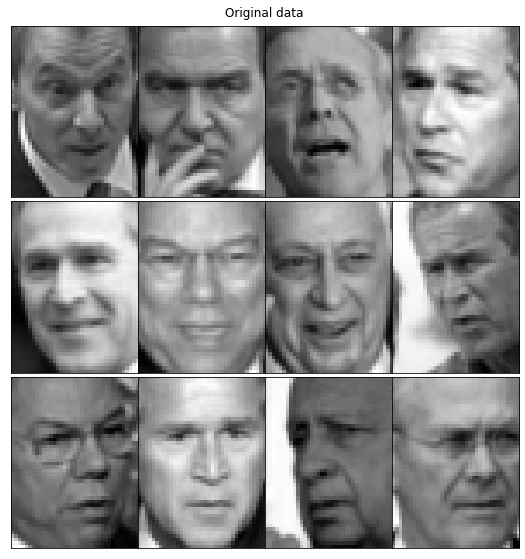

In [66]:
# Affichons les premières images
plot_images(d.data, 'Original data')

In [67]:
# Pour chaque nom de personnalités du jeu de données associé à un index, on affiche l'index, le nom, et le nombre de photo sur lequel il apparait.
for (i, name) in enumerate(d.target_names):
  print('target %d, name: %s, number of matches: %d' % (i, name, np.sum(d.target == i)))

target 0, name: Ariel Sharon, number of matches: 77
target 1, name: Colin Powell, number of matches: 236
target 2, name: Donald Rumsfeld, number of matches: 121
target 3, name: George W Bush, number of matches: 530
target 4, name: Gerhard Schroeder, number of matches: 109
target 5, name: Hugo Chavez, number of matches: 71
target 6, name: Jacques Chirac, number of matches: 52
target 7, name: Jean Chretien, number of matches: 55
target 8, name: John Ashcroft, number of matches: 53
target 9, name: Junichiro Koizumi, number of matches: 60
target 10, name: Serena Williams, number of matches: 52
target 11, name: Tony Blair, number of matches: 144


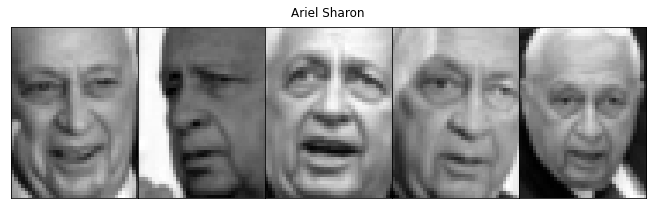

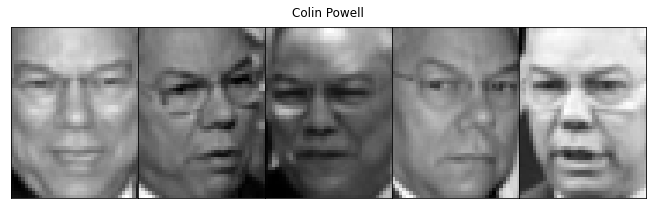

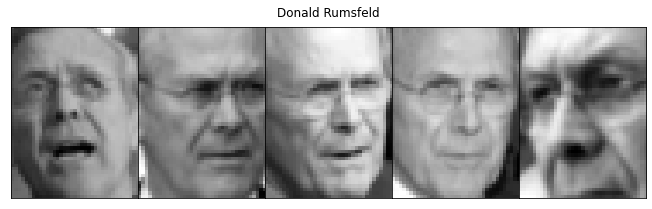

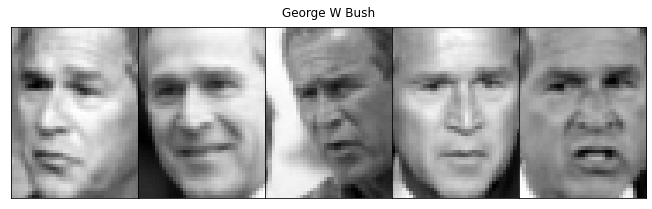

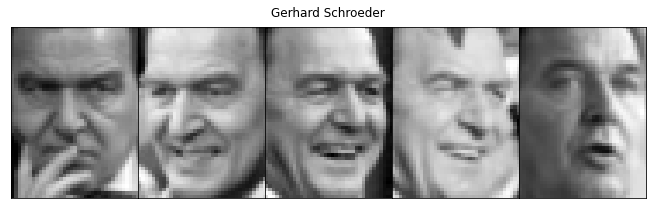

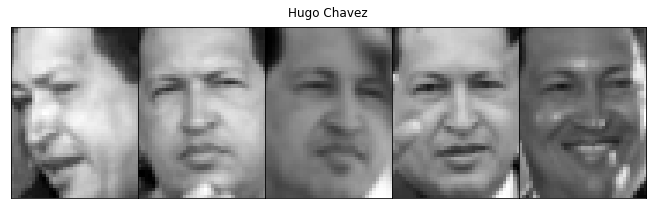

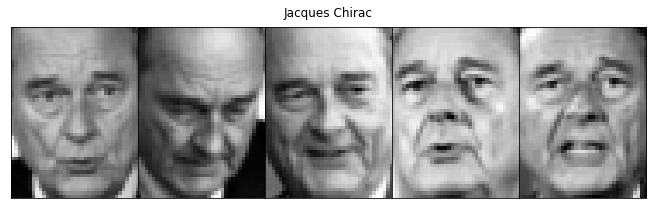

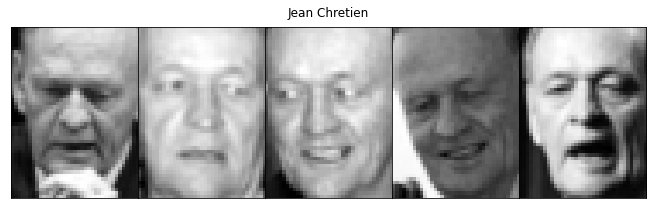

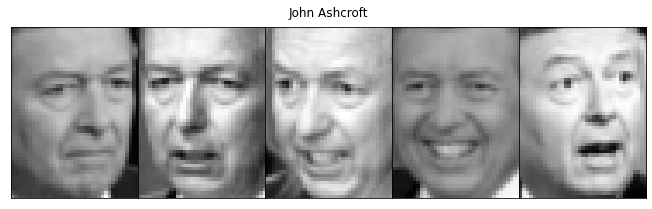

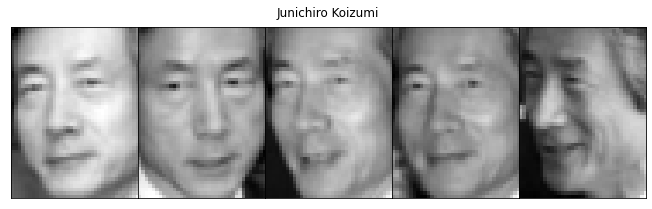

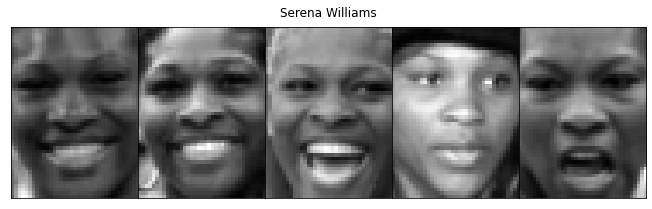

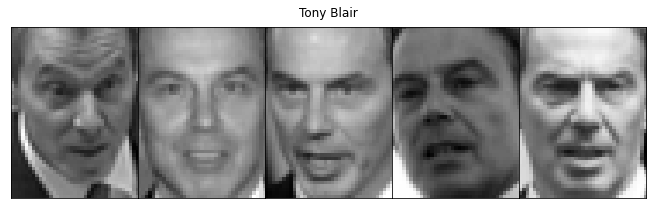

In [68]:
# Corsons un peu le problème:
# Pour chaque personnalité, affichez 5 photos de la base prises au hasard
for target, name in enumerate(d.target_names):
  samples = d.data[d.target == target]
  plot_images(samples, name, n_row=1, n_col=5, shuffle=True)

# Exploitation simple d'une ACP

## a. Apprentissage et reconstruction 

Dans les cellules suivantes, vous allez calculer une ACP sur ces données d'images.

Attention à la normalisation. Vous pouvez soit effectuer cette normalisation à la main, soit explorer un peu [la doc de sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

$\Rightarrow$ Appelez `data_pca` les données en basse dimension  
$\Rightarrow$ Appelez `reconstruction` le résultat de la fonction `pca.inverse_transform` appliqué à `data_pca`. De quoi s'agit-il ? Affichez le

In [69]:
# Créez l'objet pca, et entrainez le sur les données...
pca = PCA(n_components=200, copy=True, whiten=True, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
# Calculez la transformée des images par ACP
data_pca = pca.fit_transform(d.data)

# calculez la reconstruction correspondante
reconstruction = pca.inverse_transform(data_pca)

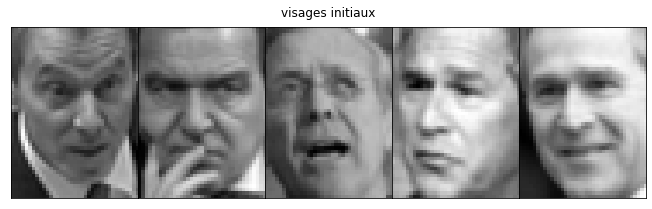

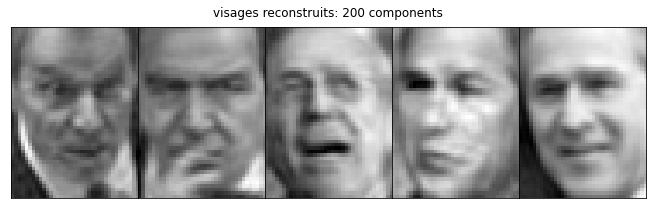

In [70]:
# Affichez sur une ligne les 5 premières images originales
plot_images(d.data, "visages initiaux", n_row=1, n_col=5, shuffle=False)

# Affichez sur une ligne leur reconstruction, en indiquant le nombre de composantes dans le titre
plot_images(reconstruction, "visages reconstruits: 200 components", n_row=1, n_col=5, shuffle=False)

In [71]:
data_pca.shape
data_pca[:,:ncomp].shape

(1560, 200)

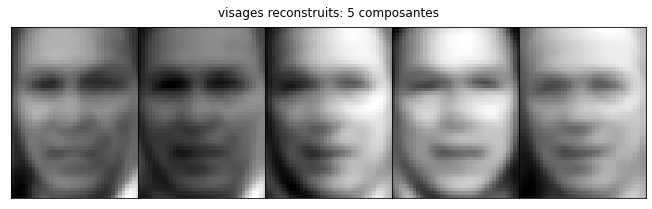

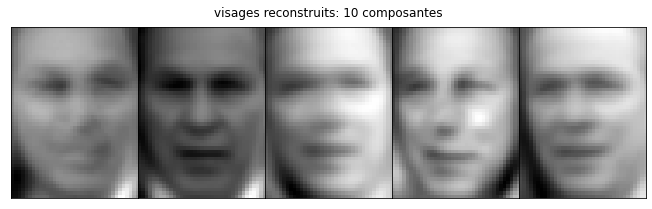

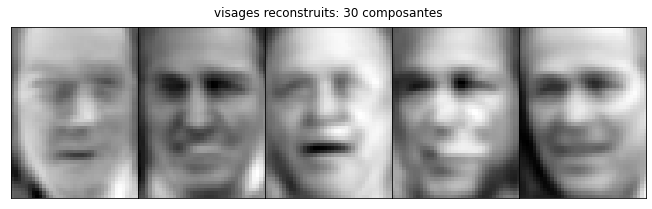

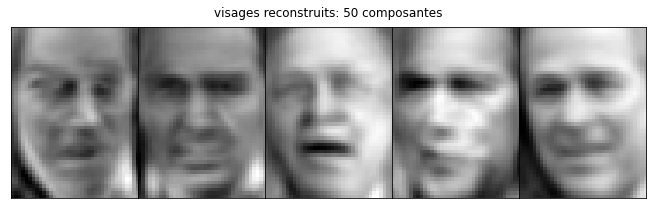

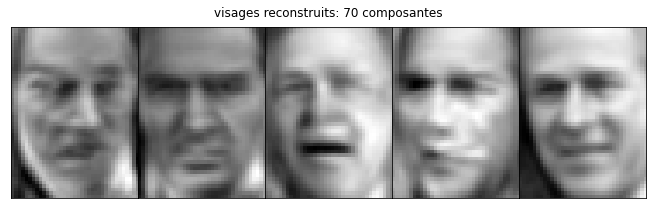

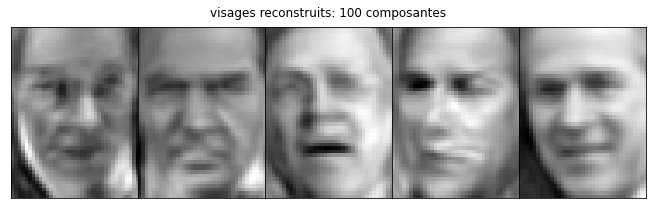

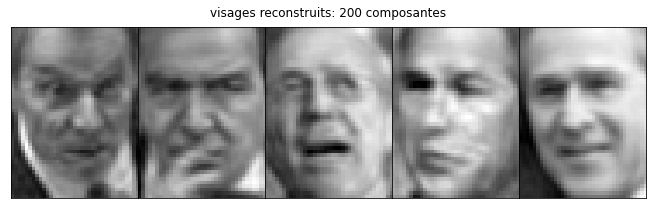

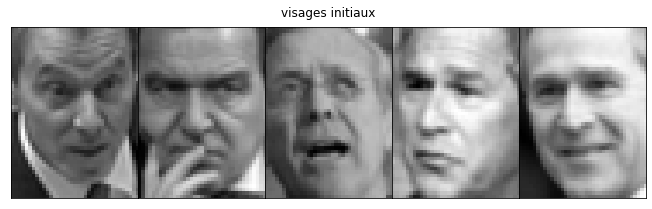

In [72]:
# Maintenant, pour les nombres de composantes suivants: 5, 10, 30, 50, 70, 100, 200, affichez les visages reconstruits sur une ligne
# puis les visages initiaux sur une ligne.
# Indice: vous avez deux options: réapprendre une ACP à chaque fois, ou bien réutiliser la même plusieurs fois.

for ncomp in [5, 10, 30, 50, 70, 100, 200]:
  pca = PCA(n_components=ncomp, whiten=True, copy=True).fit(d.data)
  data_pca = pca.transform(d.data)
  reconstruction = pca.inverse_transform(data_pca)
  plot_images(reconstruction, "visages reconstruits: %d composantes" % ncomp, n_row=1, n_col=5, shuffle=False)


# Affichez sur une ligne les 5 premières images originales
plot_images(d.data, 'visages initiaux', n_row=1, n_col=5)


## b. Affichages par scores

Voyons si le score donné par l'ACP de `scikit-learn` peut être interprétable.

> Affichez les $10$ échantillons avec le meilleur score et les $10$ avec les pires scores. Interprétez  

Pires scores:  [304.06943 352.4558  375.92072 386.64594 391.01935 403.74933 415.5431
 417.18298 426.68835 439.05618]
Meilleurs scores:  [746.0509  748.11194 750.0686  750.3979  751.9064  753.48224 757.3284
 758.31335 758.8153  760.1792 ]


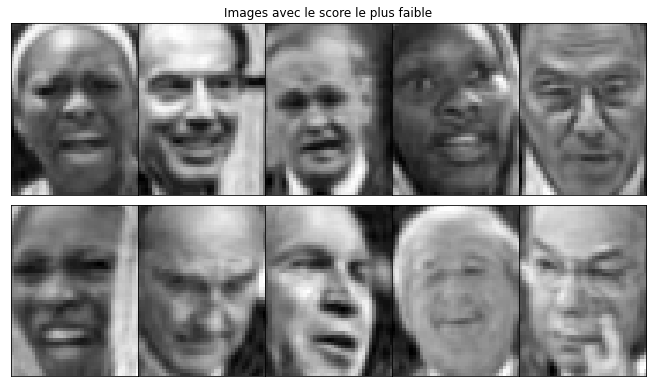

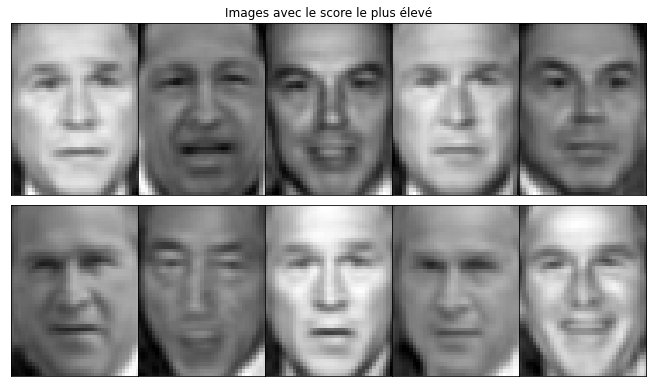

In [116]:
# extraction et tri des scores
# On n'applique pas d'exponentielle
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(d.data)

pca = PCA(n_components=200).fit(X_scaled)
X_transformed = pca.transform(X_scaled)
reconstruction_scaled = pca.inverse_transform(X_transformed)
scores = pca.score_samples(reconstruction)

reconstruction = scaler.inverse_transform(reconstruction_scaled)
scores_sorted = np.sort(scores)
print("Pires scores: ", scores_sorted[:10])
print("Meilleurs scores: ", scores_sorted[-10:])


# Affichage les 10 images avec le score le plus faible, et celles avec le score le plus élevé
min_score_index = np.array([np.argwhere(scores == scores_sorted[i]) for i in range(10)]).flatten()
max_score_index = np.array([np.argwhere(scores == scores_sorted[-(i+1)]) for i in range(10)]).flatten()

plot_images(reconstruction[min_score_index], "Images avec le score le plus faible", n_row=2, n_col=5, shuffle=False)
plot_images(reconstruction[max_score_index], "Images avec le score le plus élevé", n_row=2, n_col=5, shuffle=False)

__Interprétation__  
...

## b. Interprétation et discussion

Dans cette section, vous allez étudier certains paramètres appris par l'ACP, les afficher, et créer une cellule de texte où vous donnerez une discussion courte de ce qui vous semble pertinent.

> * Pour les affichages:  
>   $\Rightarrow$ utilisez `plt.plot`, `plt.grid`  
>   $\Rightarrow$ mettez des titres, nommez les axes
> * Pour les discussions:
>   concentrez vous sur l'essentiel: je ne noterai __PAS__ la quantité.

### `pca.explained_variance_ratio`

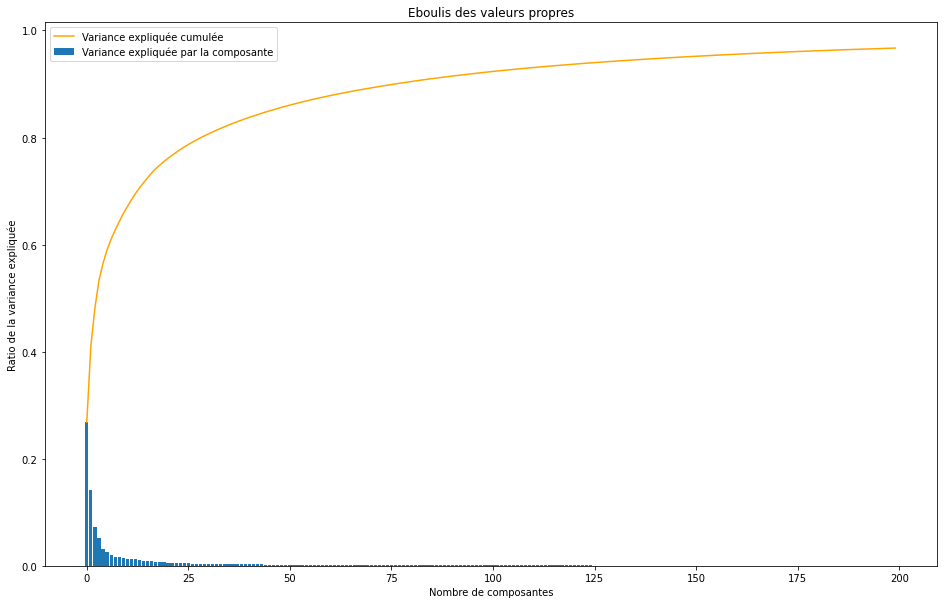

In [143]:
# Affichage de pca.explained_variance_ratio_, ainsi que de pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(16,10))
plt.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, label="Variance expliquée par la composante")
plt.plot(pca.explained_variance_ratio_.cumsum(), label="Variance expliquée cumulée", color='orange')
plt.legend()
plt.xlabel('Nombre de composantes')
plt.ylabel("Ratio de la variance expliquée")
plt.title("Eboulis des valeurs propres")
plt.show()

__De quoi s'agit-il ?__  
Du tableau des éboulis ou quelque
__Interprétez__  
Avec à peu près 25 composantes, on garde 80% de l'information (donc de la variance) contenues dans les images. 

### `pca.components_`

In [149]:
# Commencez par en affichez la dimension
print(pca.components_.shape)
# Cela devrait vous rappeler quelque chose. Affichez.
d.data.shape

(200, 1850)


(1560, 1850)

__De quoi s'agit-il ?__  
Des principaux axes (200)  expliquant la variances des caractéristiques originales (1850) 
__Interprétez__  
Sur chacun de ses axes 1850 points sont représentés

# Analyses des précipitations en France

Dans cette section, nous allons appliquer une ACP aux données de précipitations dans les grandes villes de France, déjà vues lors du premier TP. Il s'agit de rajouter l'ACP à l'arsenal d'outils de visualisation que nous avons vus. 

In [177]:
# imports
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

# Chargeons les données
raw_data = pandas.read_csv('https://husson.github.io/img/pluie.csv',
                       encoding = "ISO-8859-1", sep=';')

# renommons la première colonne "Ville"
raw_data = raw_data.rename(columns = {raw_data.columns[0]:'Ville'})

# choisissons cette colonne en index
raw_data = raw_data.set_index('Ville')

In [181]:
!pip install adjustText
from adjustText import adjust_text

## a. Utilisation simple ACP

Pour la suite:
1. Affichez une ACP des données de précipitations en 2D (deux composantes), avec pour chaque ville:
   * Son nom
   * La taille du point dépendant du volume total de précipitations
   * La couleur du point dépendant de la région.
2. Affichez une ACP du nombre de jours de pluie, calculée sur les colonnes (donc les mois), avec le nom des mois et la taille des points dépendants du nombre de jours de pluie moyen par mois. 

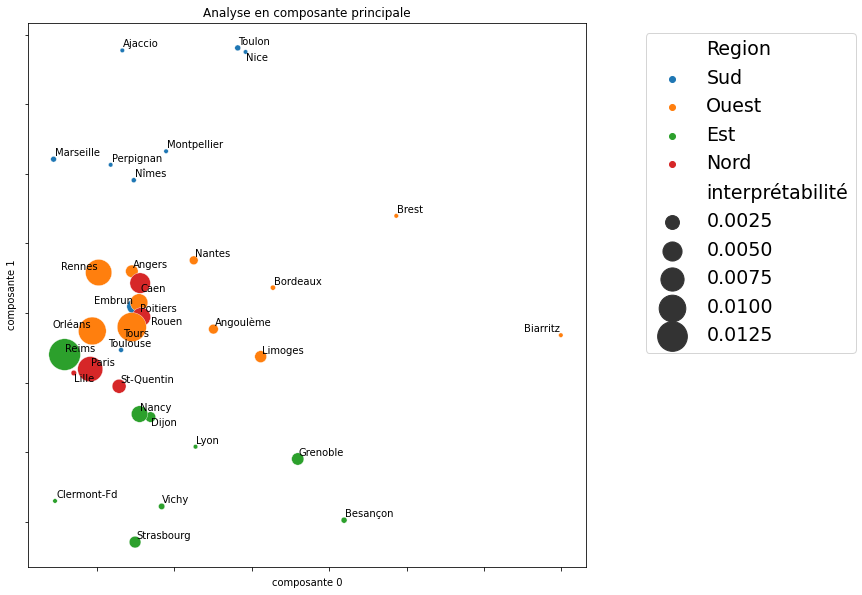

In [182]:

# ACP des précipitations par ville
df_precipitations = raw_data.iloc[:,:12]
scaler = StandardScaler().fit(df_precipitations)
X_scaled = scaler.transform(df_precipitations)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_precipitations["interprétabilité"] = np.exp(pca.score_samples(X_scaled))
df_precipitations["composante 0"] = X_pca[:,0]
df_precipitations["composante 1"] = X_pca[:,1]

df_precipitations["Region"] = raw_data.Géographie
# le code est presque le même, on rajoute juste une information de taille
g = sns.scatterplot(x='composante 0',
                y='composante 1',
                size='interprétabilité',
                sizes=(20,1000),
                data=df_precipitations,
                hue="Region")

# on agrandit la figure, on annote...
g.figure.set_size_inches(10,10)
ax = plt.gca()
texts = []
for i, (text_x,text_y) in enumerate(X_pca):
  texts.append(ax.annotate(df_precipitations.index[i], (text_x,text_y)))
adjust_text(texts)

## on supprime les informations sur les axes, on rajout un titre et une légende
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])
plt.title('Analyse en composante principale');
plt.gca().legend(prop={'size': 19}, bbox_to_anchor=(1.5, 1.0));


In [165]:
raw_data.head()

,JANVIERp,FEVRIERp,MARSp,AVRILp,MAIp,JUINp,JUILLETp,AOUTp,SEPTEMBREp,OCTOBREp,NOVEMBREp,DECEMBREp,Précipitations annuelles,JANVIERnb.j.pl,FEVRIERnb.j.pl,MARSnb.j.pl,AVRILnb.j.pl,MAInb.j.pl,JUINnb.j.pl,JUILLETnb.j.pl,AOUTnb.j.pl,SEPTEMBREnb.j.pl,OCTOBREnb.j.pl,NOVEMBREnb.j.pl,DECEMBREnb.j.pl,Nombre annuel de jours de pluie,Température moyenne annuelle,Amplitude annuelle des températures,Insolation annuelle,Latitude,Longitude,Précipitations de mai à aout,Précipitations sept-oct,Géographie
Ville,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ajaccio,78.0,69.0,51.0,39.0,43.0,23.0,10.0,15.0,43.0,81.0,105.0,96.0,653.0,12.0,10.0,9.0,9.0,8.0,4.0,1.0,2.0,6.0,10.0,11.0,13.0,95.0,14.71,14.5,2811.0,41.55,8.44,13.9,25.8,Sud
Angers,65.0,50.0,60.0,45.0,50.0,55.0,35.0,60.0,55.0,65.0,80.0,70.0,690.0,16.0,13.0,12.0,12.0,13.0,10.0,11.0,11.0,12.0,13.0,15.0,16.0,154.0,11.28,14.5,1899.0,47.28,-0.33,29.0,30.8,Ouest
Angoulème,79.0,68.0,64.0,62.0,70.0,58.0,53.0,66.0,69.0,70.0,79.0,88.0,826.0,16.0,14.0,13.0,12.0,14.0,11.0,12.0,12.0,12.0,13.0,15.0,16.0,160.0,12.02,14.9,1989.0,45.39,0.09,29.9,31.0,Ouest
Besançon,94.0,87.0,75.0,74.0,86.0,107.0,80.0,116.0,106.0,78.0,92.0,93.0,1088.0,17.0,14.0,12.0,14.0,14.0,14.0,14.0,13.0,13.0,14.0,15.0,15.0,169.0,10.04,17.6,1897.0,47.15,6.02,35.8,35.5,Est
Biarritz,128.0,105.0,98.0,102.0,100.0,91.0,69.0,123.0,155.0,152.0,175.0,176.0,1474.0,16.0,14.0,13.0,15.0,17.0,14.0,13.0,13.0,14.0,15.0,16.0,17.0,177.0,13.58,12.3,1921.0,43.29,-1.34,26.0,36.8,Ouest


In [78]:
# ACP du nombre de jours de pluie par mois
...